**GEOSAT 2025**
**Building Extraction**

> Mohammed LAYELMAM



Ce script s’inscrit dans une démarche GEOAI (Geospatial Artificial Intelligence) visant à combiner l’analyse d’images satellitaires et l’intelligence artificielle pour la détection automatique des bâtiments dans des zones urbaines.

En utilisant la plateforme Google Earth Engine (GEE) et les bibliothèques Python (Folium, Earth Engine API), ce code permet :
- De charger et visualiser une image Sentinel-2 en composition RGB,
- D’afficher les résultats d’une classification binaire (bâti / non bâti) réalisée via des techniques
  de Machine Learning ou de traitement d’images dans GEE,
- De comparer de manière interactive les deux couches à l’aide d’un composant de visualisation en balayage (swipe),
- D’intégrer une légende explicative des classes détectées.

Ce travail illustre une application concrète de la GEOAI dans l’analyse de l’occupation du sol, la cartographie urbaine et la planification territoriale intelligente.


**Étape 1 : Installer et initialiser Earth**

In [51]:
!pip install earthengine-api --upgrade --quiet

import ee
import geemap

# Authentification
ee.Authenticate()

# Vous pouvez utiliser le nom du projet Earth Engine affiché ici : https://console.cloud.google.com/cloud-resource-manager
ee.Initialize(project='my-project-95508-1685445654136')  # ou un autre projet auquel vous avez accès

**Étape 2 : Définir la zone d'étude**

In [52]:
# Exemple : une partie de Rabat, Maroc
aoi = ee.Geometry.Rectangle([-6.860, 33.97, -6.820, 34.00])

**Étape 3 : Charger les images Sentinel-2**

In [53]:
sentinel = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
    .filterBounds(aoi) \
    .filterDate('2024-01-01', '2024-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .median() \
    .clip(aoi)

**Étape 4 : Sélection des bandes utiles**

In [54]:
bands = ['B2', 'B3', 'B4', 'B8']  # Blue, Green, Red, NIR
image = sentinel.select(bands)

**Étape 5 : Créer des échantillons de données d'entraînement**

In [55]:
# Zones construites
built = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point(-6.845, 33.985), {'class': 1}),
    ee.Feature(ee.Geometry.Point(-6.846, 33.986), {'class': 1}),
    # Ajoutez d'autres points
])

# Zones non construites
non_built = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point(-6.830, 33.980), {'class': 0}),
    ee.Feature(ee.Geometry.Point(-6.831, 33.981), {'class': 0}),
    # Ajoutez d'autres points
])

training_points = built.merge(non_built)

**Étape 6 : Extraction des données pour entraîner le modèle**

In [56]:
training = image.sampleRegions(
    collection=training_points,
    properties=['class'],
    scale=10
)

**Étape 7 : Entraînement du modèle Random Forest**

In [57]:
classifier = ee.Classifier.smileRandomForest(50).train(
    features=training,
    classProperty='class',
    inputProperties=bands
)

**Étape 8 : Appliquer le classificateur**

In [58]:
classified = image.classify(classifier)

**Étape 9 : Affichage des résultats**

In [59]:
import folium
from folium import plugins

# Fonction utilitaire pour afficher des objets Earth Engine
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# Création de la carte
map = folium.Map(location=[33.985, -6.84], zoom_start=15)

# Affichage de l'image classifiée
map.add_ee_layer(classified, {'min': 0, 'max': 1, 'palette': ['white', 'red']}, 'Buildings')

# Ajout des contrôles
map.add_child(folium.LayerControl())
map

In [60]:

# Obtenir les URLs pour le DualMap
sat_mapid = ee.Image(sentinel).getMapId(vis_sat)
class_mapid = ee.Image(classified).getMapId(vis_class)

# Créer une carte DualMap
dual_map = plugins.DualMap(location=[33.985, -6.84], zoom_start=14)

# Ajouter l’image satellite à gauche
folium.TileLayer(
    tiles=sat_mapid['tile_fetcher'].url_format,
    attr='Sentinel-2 RGB',
    name='Image Satellite',
    overlay=True,
    control=True
).add_to(dual_map.m1)

# Ajouter la classification à droite
folium.TileLayer(
    tiles=class_mapid['tile_fetcher'].url_format,
    attr='Classification',
    name='Bâtiments',
    overlay=True,
    control=True
).add_to(dual_map.m2)

# Ajouter la légende (à gauche seulement pour éviter les doublons)
legend_html = '''
<div style="
    position: fixed;
    bottom: 50px; left: 50px; width: 180px; height: 90px;
    background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
    padding: 10px;">
    <b>Classification Bâtiments</b><br>
    <i style="background:white; width:12px; height:12px; float:left; margin-right:5px;"></i> Non bâti<br>
    <i style="background:red; width:12px; height:12px; float:left; margin-right:5px;"></i> Bâti détecté
</div>
'''
dual_map.m1.get_root().html.add_child(folium.Element(legend_html))

# Afficher la carte
dual_map


**Étape 10 : Vectoriser et exporter l'image classifiée**

In [21]:
building_vectors = classified.selfMask().reduceToVectors(
    geometry = ee.Geometry.Rectangle([-6.860, 33.97, -6.820, 34.00]),
    scale=10,
    geometryType='polygon',
    labelProperty='class',
    maxPixels=1e10
)

# Étape 2 : Export en SHP vers Google Drive
export_task = ee.batch.Export.table.toDrive(
    collection=building_vectors,
    description='Export_Building_Shapes',
    folder='GEE_Export',  # Créez-le dans Drive si besoin
    fileFormat='SHP'
)
export_task.start()

print("✅ Export lancé vers votre Google Drive dans le dossier 'GEE_Export'")

✅ Export lancé vers votre Google Drive dans le dossier 'GEE_Export'


**Etape 11 : Répartition de la Surface Bâtie en Ha**

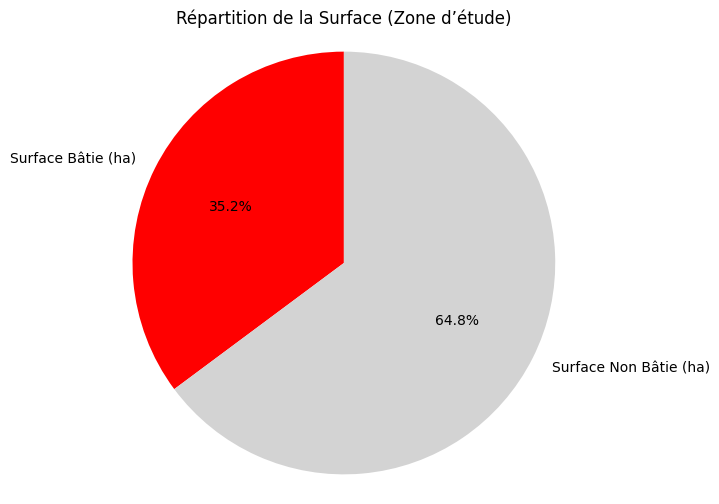

In [61]:
import matplotlib.pyplot as plt

# Reclassifier pour ne garder que les pixels bâtis (=1)
batiments = classified.eq(1)

# Définir la zone d’étude (ou utiliser une shapefile déjà importée)
zone_etude = ee.Geometry.Rectangle([-6.86, 33.98, -6.83, 34.0])  # Exemple Rabat

# Calcul de la superficie des pixels bâtis
# 1 pixel Sentinel-2 = 10m x 10m = 100 m²
pixel_area = ee.Image.pixelArea().updateMask(batiments)

# Surface totale bâtie en m²
surface_batie_m2 = pixel_area.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=zone_etude,
    scale=10,
    maxPixels=1e13
).getInfo()

# Valeurs extraites
surface_batie = surface_batie_m2['area'] if 'area' in surface_batie_m2 else 0
surface_totale = zone_etude.area().getInfo()
surface_non_batie = surface_totale - surface_batie

# Conversion en hectares
surface_batie_ha = surface_batie / 10000
surface_non_batie_ha = surface_non_batie / 10000

# Affichage du graphe
labels = ['Surface Bâtie (ha)', 'Surface Non Bâtie (ha)']
sizes = [surface_batie_ha, surface_non_batie_ha]
colors = ['red', 'lightgray']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Répartition de la Surface (Zone d’étude)")
plt.axis('equal')
plt.show()